In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pqcd

from pqcd.utils import (
    to_GeV_per_cubic_femtometre, 
    to_nucleons_per_cubic_femtometre, 
    nsat
)

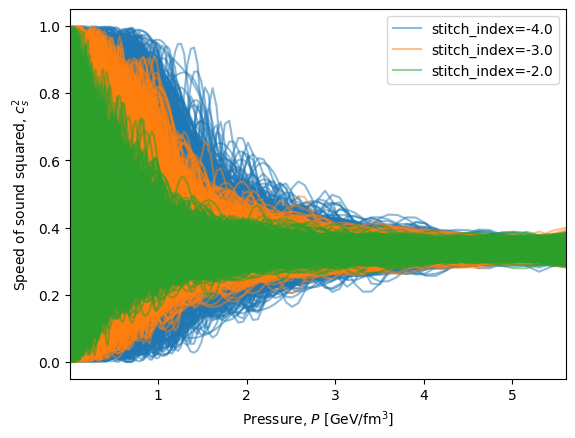

In [3]:
# Campaign numbers to compare
sets = [2, 0, 1]

# Campaign descriptions
set_keys = {
    0: 'stitch_index=-3.0',
    1: 'stitch_index=-2.0',
    2: 'stitch_index=-4.0',
}

# Number of EOS draws
N = 1000

min_pressure = to_GeV_per_cubic_femtometre(1e10)
max_pressure = to_GeV_per_cubic_femtometre(1e16)

fig, ax = plt.subplots()

for i, s in enumerate(sets):
    for variety in ['had', 'hyp', 'qrk']:
        for n in range(N):

            df = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/eos-draw-{n:06}.csv')

            pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
            energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
            number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)

            chemical_potential = (energy_density+pressure)/number_density
            speed_of_sound_squared = np.gradient(pressure, energy_density)

            ax.plot(
                pressure,
                speed_of_sound_squared, 
                alpha=0.5, 
                c=f'C{i}',
                label=set_keys[s] if (n==0) and (variety=='had') else None
                )

ax.legend()

ax.set_xlim(min_pressure, max_pressure)

ax.set_xlabel(r'Pressure, $P$ [GeV/fm$^3$]')
_ = ax.set_ylabel(r'Speed of sound squared, $c_s^2$')

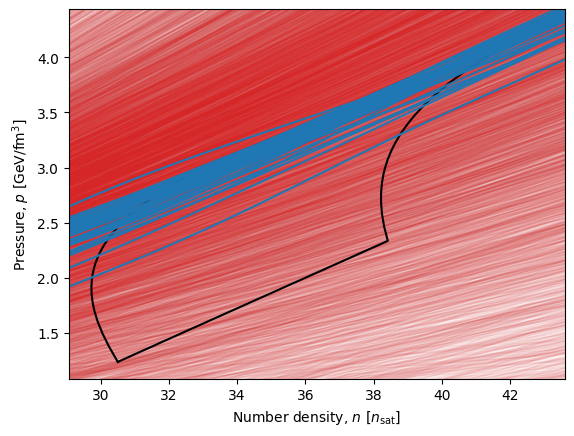

In [4]:
N_samp = 1000

good_EOSs = {s: [] for s in sets}

pqcd_region_dict = pqcd.get_pqcd_region()

fig, ax = plt.subplots()

ax.plot(
    pqcd_region_dict['left_n_boundary']/nsat, 
    pqcd_region_dict['left_p_boundary'], 
    c='k',
    zorder=2
    )

ax.plot(
    pqcd_region_dict['right_n_boundary']/nsat, 
    pqcd_region_dict['right_p_boundary'], 
    c='k',
    zorder=2
    )

xlim = ax.get_xlim()
ylim = ax.get_ylim()

for s in sets:
    for variety in ['had', 'hyp', 'qrk']:
        for ni in range(N_samp):

            eos = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/eos-draw-{ni:06}.csv')
            
            if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
                good_EOSs[s].append((variety, ni))
                ax.plot(
                    to_nucleons_per_cubic_femtometre(eos.baryon_density)/nsat,
                    to_GeV_per_cubic_femtometre(eos.pressurec2),
                    c='C0'
                )
            
            else:
                ax.plot(
                    to_nucleons_per_cubic_femtometre(eos.baryon_density)/nsat,
                    to_GeV_per_cubic_femtometre(eos.pressurec2),
                    c='C3',
                    alpha=0.05,
                    lw=1,
                    zorder=0.5
                )

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel(r'Number density, $n$ [$n_{\rm sat}$]')
_ = ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

In [5]:
for key, label in set_keys.items():
    print(f'{label}: {len(good_EOSs[key])} good EOSs')

stitch_index=-3.0: 16 good EOSs
stitch_index=-2.0: 12 good EOSs
stitch_index=-4.0: 17 good EOSs


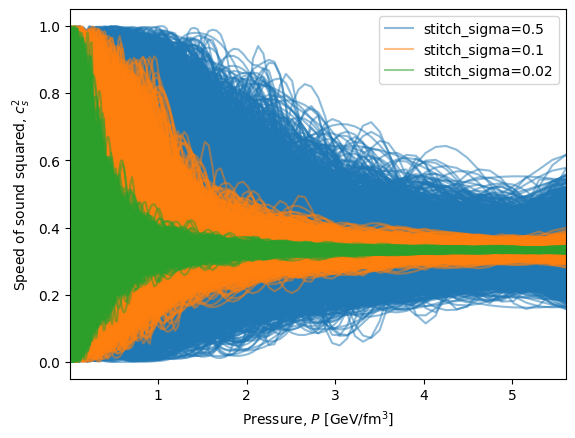

In [6]:
# Campaign numbers to compare
sets = [3, 0, 4]

# Campaign descriptions
set_keys = {
    4: 'stitch_sigma=0.02',
    0: 'stitch_sigma=0.1',
    3: 'stitch_sigma=0.5',
}

# Number of EOS draws
N = 1000

min_pressure = to_GeV_per_cubic_femtometre(1e10)
max_pressure = to_GeV_per_cubic_femtometre(1e16)

fig, ax = plt.subplots()

for i, s in enumerate(sets):
    for variety in ['had', 'hyp', 'qrk']:
        for n in range(N):

            df = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/eos-draw-{n:06}.csv')

            pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
            energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
            number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)

            chemical_potential = (energy_density+pressure)/number_density
            speed_of_sound_squared = np.gradient(pressure, energy_density)

            ax.plot(
                pressure,
                speed_of_sound_squared, 
                alpha=0.5, 
                c=f'C{i}',
                label=set_keys[s] if (n==0) and (variety=='had') else None
                )

ax.legend()

ax.set_xlim(min_pressure, max_pressure)

ax.set_xlabel(r'Pressure, $P$ [GeV/fm$^3$]')
_ = ax.set_ylabel(r'Speed of sound squared, $c_s^2$')

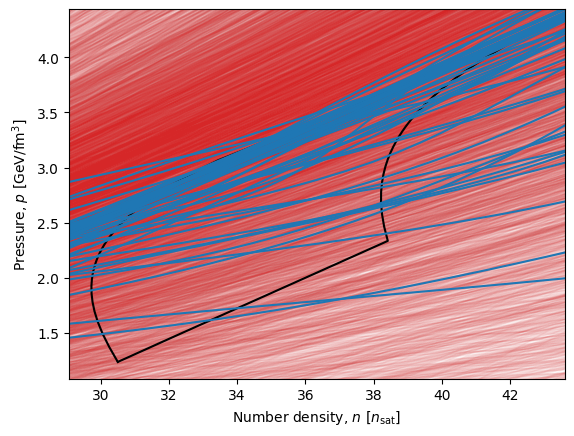

In [7]:
N_samp = 1000

good_EOSs = {s: [] for s in sets}

pqcd_region_dict = pqcd.get_pqcd_region()

fig, ax = plt.subplots()

ax.plot(
    pqcd_region_dict['left_n_boundary']/nsat, 
    pqcd_region_dict['left_p_boundary'], 
    c='k',
    zorder=2
    )

ax.plot(
    pqcd_region_dict['right_n_boundary']/nsat, 
    pqcd_region_dict['right_p_boundary'], 
    c='k',
    zorder=2
    )

xlim = ax.get_xlim()
ylim = ax.get_ylim()

for s in sets:
    for variety in ['had', 'hyp', 'qrk']:
        for ni in range(N_samp):

            eos = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/eos-draw-{ni:06}.csv')
            
            if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
                good_EOSs[s].append((variety, ni))
                ax.plot(
                    to_nucleons_per_cubic_femtometre(eos.baryon_density)/nsat,
                    to_GeV_per_cubic_femtometre(eos.pressurec2),
                    c='C0'
                )
            
            else:
                ax.plot(
                    to_nucleons_per_cubic_femtometre(eos.baryon_density)/nsat,
                    to_GeV_per_cubic_femtometre(eos.pressurec2),
                    c='C3',
                    alpha=0.05,
                    lw=1,
                    zorder=0.5
                )

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel(r'Number density, $n$ [$n_{\rm sat}$]')
_ = ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

In [8]:
for key, label in set_keys.items():
    print(f'{label}: {len(good_EOSs[key])} good EOSs')

stitch_sigma=0.02: 6 good EOSs
stitch_sigma=0.1: 16 good EOSs
stitch_sigma=0.5: 29 good EOSs


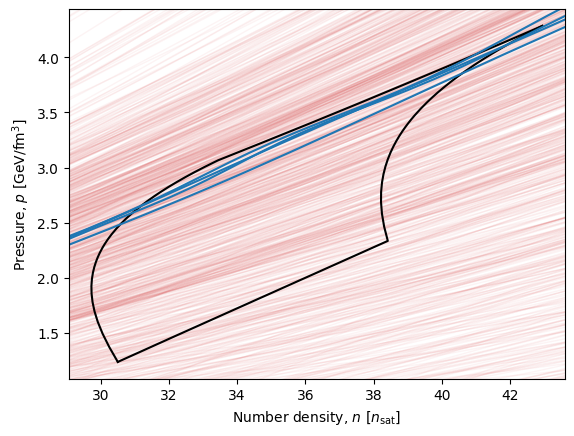

In [9]:
# Campaign numbers to compare
sets = [5]

# Campaign descriptions
set_keys = {
    5: 'qrk alf only',
}

N_samp = 1000

good_EOSs = {s: [] for s in sets}

pqcd_region_dict = pqcd.get_pqcd_region()

fig, ax = plt.subplots()

ax.plot(
    pqcd_region_dict['left_n_boundary']/nsat, 
    pqcd_region_dict['left_p_boundary'], 
    c='k',
    zorder=2
    )

ax.plot(
    pqcd_region_dict['right_n_boundary']/nsat, 
    pqcd_region_dict['right_p_boundary'], 
    c='k',
    zorder=2
    )

xlim = ax.get_xlim()
ylim = ax.get_ylim()

for s in sets:
    for variety in ['qrk']:
        for ni in range(N_samp):

            eos = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/eos-draw-{ni:06}.csv')
            
            if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
                good_EOSs[s].append((variety, ni))
                ax.plot(
                    to_nucleons_per_cubic_femtometre(eos.baryon_density)/nsat,
                    to_GeV_per_cubic_femtometre(eos.pressurec2),
                    c='C0'
                )
            
            else:
                ax.plot(
                    to_nucleons_per_cubic_femtometre(eos.baryon_density)/nsat,
                    to_GeV_per_cubic_femtometre(eos.pressurec2),
                    c='C3',
                    alpha=0.05,
                    lw=1,
                    zorder=0.5
                )

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel(r'Number density, $n$ [$n_{\rm sat}$]')
_ = ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

In [10]:
for key, label in set_keys.items():
    print(f'{label}: {len(good_EOSs[key])} good EOSs')

qrk alf only: 4 good EOSs


default mean: 22 good EOSs


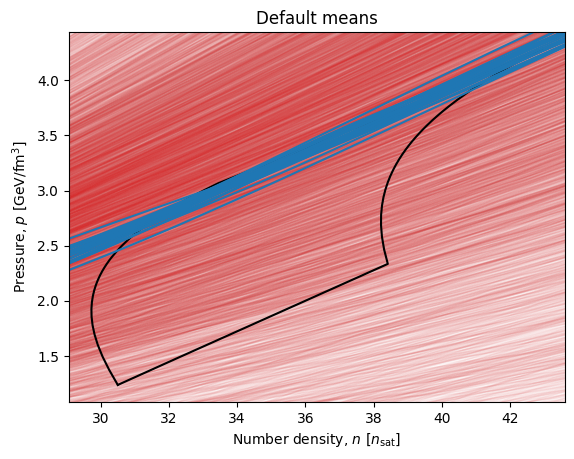

In [11]:
# Campaign numbers to compare
sets = [6]

# Campaign descriptions
set_keys = {
    6: 'default mean',
}

N_samp = 2000

good_EOSs = {s: [] for s in sets}

pqcd_region_dict = pqcd.get_pqcd_region()

fig, ax = plt.subplots()

ax.plot(
    pqcd_region_dict['left_n_boundary']/nsat, 
    pqcd_region_dict['left_p_boundary'], 
    c='k',
    zorder=2
    )

ax.plot(
    pqcd_region_dict['right_n_boundary']/nsat, 
    pqcd_region_dict['right_p_boundary'], 
    c='k',
    zorder=2
    )

xlim = ax.get_xlim()
ylim = ax.get_ylim()

for s in sets:
    for variety in ['had', 'hyp', 'qrk']:
        for n in range(N_samp):

            eos = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv')
            
            if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
                good_EOSs[s].append((variety, n))
                ax.plot(
                    to_nucleons_per_cubic_femtometre(eos.baryon_density)/nsat,
                    to_GeV_per_cubic_femtometre(eos.pressurec2),
                    c='C0'
                )
            
            else:
                ax.plot(
                    to_nucleons_per_cubic_femtometre(eos.baryon_density)/nsat,
                    to_GeV_per_cubic_femtometre(eos.pressurec2),
                    c='C3',
                    alpha=0.05,
                    lw=1,
                    zorder=0.5
                )

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel(r'Number density, $n$ [$n_{\rm sat}$]')
ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

ax.set_title('Default means')

for key, label in set_keys.items():
    print(f'{label}: {len(good_EOSs[key])} good EOSs')

custom mean; single pQCD-consistent EOS with some smoothing: 22 good EOSs


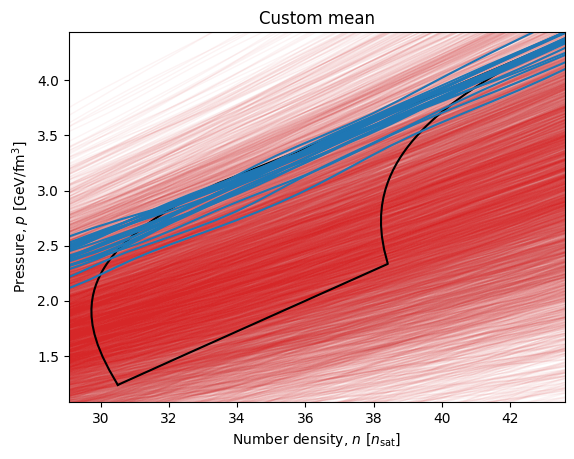

In [2]:
# Campaign numbers to compare
sets = [8]

# Campaign descriptions
set_keys = {
    8: 'custom mean; single pQCD-consistent EOS with some smoothing',
}

N_samp = 5000

good_EOSs = {s: [] for s in sets}

pqcd_region_dict = pqcd.get_pqcd_region()

fig, ax = plt.subplots()

ax.plot(
    pqcd_region_dict['left_n_boundary']/nsat, 
    pqcd_region_dict['left_p_boundary'], 
    c='k',
    zorder=2
    )

ax.plot(
    pqcd_region_dict['right_n_boundary']/nsat, 
    pqcd_region_dict['right_p_boundary'], 
    c='k',
    zorder=2
    )

xlim = ax.get_xlim()
ylim = ax.get_ylim()

for s in sets:
    for variety in ['qrk']:
        for n in range(N_samp):

            eos = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv')
            
            if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
                good_EOSs[s].append((variety, n))
                ax.plot(
                    to_nucleons_per_cubic_femtometre(eos.baryon_density)/nsat,
                    to_GeV_per_cubic_femtometre(eos.pressurec2),
                    c='C0'
                )
            
            else:
                ax.plot(
                    to_nucleons_per_cubic_femtometre(eos.baryon_density)/nsat,
                    to_GeV_per_cubic_femtometre(eos.pressurec2),
                    c='C3',
                    alpha=0.05,
                    lw=1,
                    zorder=0.5
                )

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel(r'Number density, $n$ [$n_{\rm sat}$]')
ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

ax.set_title('Custom mean')

for key, label in set_keys.items():
    print(f'{label}: {len(good_EOSs[key])} good EOSs')

custom mean: 15 good EOSs


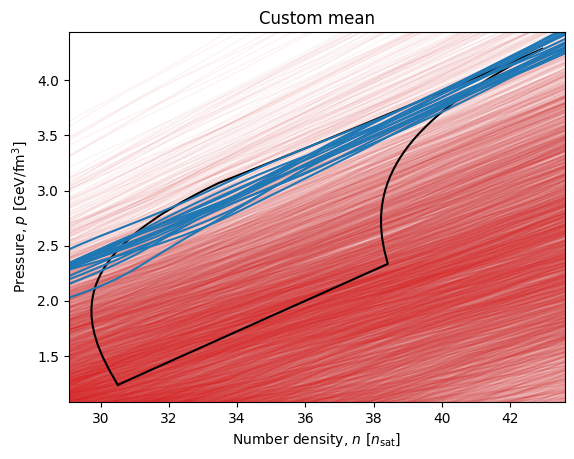

In [2]:
# Campaign numbers to compare
sets = [9]

# Campaign descriptions
set_keys = {
    9: 'custom mean',
}

N_samp = 5000

good_EOSs = {s: [] for s in sets}

pqcd_region_dict = pqcd.get_pqcd_region()

fig, ax = plt.subplots()

ax.plot(
    pqcd_region_dict['left_n_boundary']/nsat, 
    pqcd_region_dict['left_p_boundary'], 
    c='k',
    zorder=2
    )

ax.plot(
    pqcd_region_dict['right_n_boundary']/nsat, 
    pqcd_region_dict['right_p_boundary'], 
    c='k',
    zorder=2
    )

xlim = ax.get_xlim()
ylim = ax.get_ylim()

for s in sets:
    for variety in ['qrk']:
        for n in range(N_samp):

            eos = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv')
            
            if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
                good_EOSs[s].append((variety, n))
                ax.plot(
                    to_nucleons_per_cubic_femtometre(eos.baryon_density)/nsat,
                    to_GeV_per_cubic_femtometre(eos.pressurec2),
                    c='C0'
                )
            
            else:
                ax.plot(
                    to_nucleons_per_cubic_femtometre(eos.baryon_density)/nsat,
                    to_GeV_per_cubic_femtometre(eos.pressurec2),
                    c='C3',
                    alpha=0.05,
                    lw=1,
                    zorder=0.5
                )

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel(r'Number density, $n$ [$n_{\rm sat}$]')
ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

ax.set_title('Custom mean')

for key, label in set_keys.items():
    print(f'{label}: {len(good_EOSs[key])} good EOSs')

custom mean: 4 good EOSs


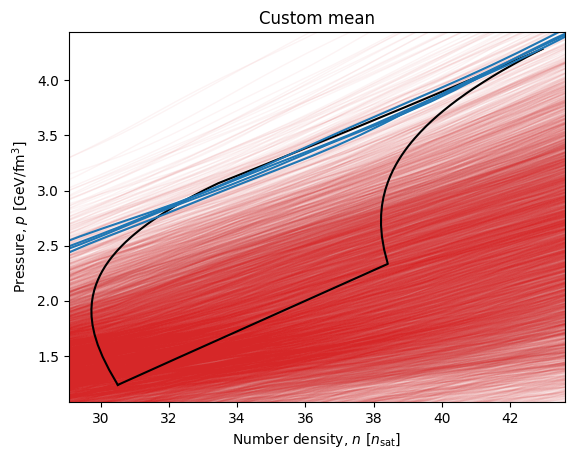

In [2]:
# Campaign numbers to compare
sets = [10]

# Campaign descriptions
set_keys = {
    10: 'custom mean',
}

N_samp = 5000

good_EOSs = {s: [] for s in sets}

pqcd_region_dict = pqcd.get_pqcd_region()

fig, ax = plt.subplots()

ax.plot(
    pqcd_region_dict['left_n_boundary']/nsat, 
    pqcd_region_dict['left_p_boundary'], 
    c='k',
    zorder=2
    )

ax.plot(
    pqcd_region_dict['right_n_boundary']/nsat, 
    pqcd_region_dict['right_p_boundary'], 
    c='k',
    zorder=2
    )

xlim = ax.get_xlim()
ylim = ax.get_ylim()

for s in sets:
    for variety in ['qrk']:
        for n in range(N_samp):

            eos = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv')
            
            if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
                good_EOSs[s].append((variety, n))
                ax.plot(
                    to_nucleons_per_cubic_femtometre(eos.baryon_density)/nsat,
                    to_GeV_per_cubic_femtometre(eos.pressurec2),
                    c='C0'
                )
            
            else:
                ax.plot(
                    to_nucleons_per_cubic_femtometre(eos.baryon_density)/nsat,
                    to_GeV_per_cubic_femtometre(eos.pressurec2),
                    c='C3',
                    alpha=0.05,
                    lw=1,
                    zorder=0.5
                )

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel(r'Number density, $n$ [$n_{\rm sat}$]')
ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

ax.set_title('Custom mean')

for key, label in set_keys.items():
    print(f'{label}: {len(good_EOSs[key])} good EOSs')

custom mean: 38 good EOSs


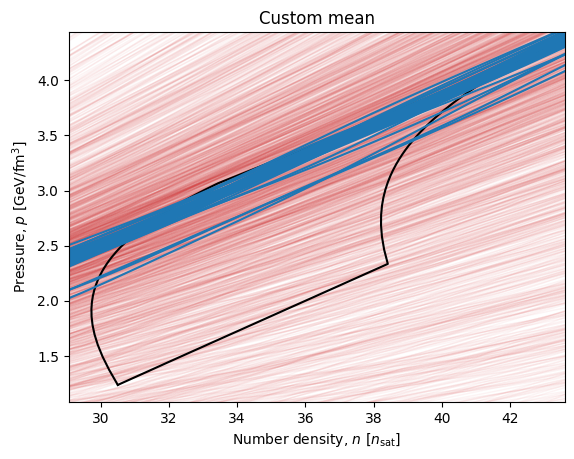

In [2]:
# Campaign numbers to compare
sets = [14]

# Campaign descriptions
set_keys = {
    14: 'custom mean',
}

N_samp = 2000

good_EOSs = {s: [] for s in sets}

pqcd_region_dict = pqcd.get_pqcd_region()

fig, ax = plt.subplots()

ax.plot(
    pqcd_region_dict['left_n_boundary']/nsat, 
    pqcd_region_dict['left_p_boundary'], 
    c='k',
    zorder=2
    )

ax.plot(
    pqcd_region_dict['right_n_boundary']/nsat, 
    pqcd_region_dict['right_p_boundary'], 
    c='k',
    zorder=2
    )

xlim = ax.get_xlim()
ylim = ax.get_ylim()

for s in sets:
    for variety in ['cus']:
        for n in range(N_samp):

            eos = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv')
            
            if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
                good_EOSs[s].append((variety, n))
                ax.plot(
                    to_nucleons_per_cubic_femtometre(eos.baryon_density)/nsat,
                    to_GeV_per_cubic_femtometre(eos.pressurec2),
                    c='C0'
                )
            
            else:
                ax.plot(
                    to_nucleons_per_cubic_femtometre(eos.baryon_density)/nsat,
                    to_GeV_per_cubic_femtometre(eos.pressurec2),
                    c='C3',
                    alpha=0.05,
                    lw=1,
                    zorder=0.5
                )

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel(r'Number density, $n$ [$n_{\rm sat}$]')
ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

ax.set_title('Custom mean')

for key, label in set_keys.items():
    print(f'{label}: {len(good_EOSs[key])} good EOSs')

In [3]:
100*(38/2000)

1.9

custom mean: 12 good EOSs


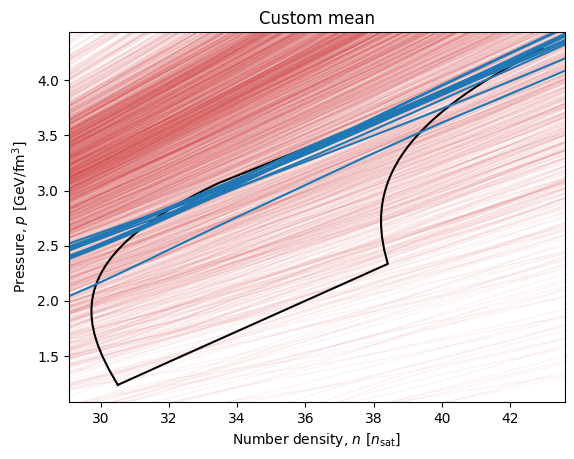

In [2]:
# Campaign numbers to compare
sets = [15]

# Campaign descriptions
set_keys = {
    15: 'custom mean',
}

N_samp = 2000

good_EOSs = {s: [] for s in sets}

pqcd_region_dict = pqcd.get_pqcd_region()

fig, ax = plt.subplots()

ax.plot(
    pqcd_region_dict['left_n_boundary']/nsat, 
    pqcd_region_dict['left_p_boundary'], 
    c='k',
    zorder=2
    )

ax.plot(
    pqcd_region_dict['right_n_boundary']/nsat, 
    pqcd_region_dict['right_p_boundary'], 
    c='k',
    zorder=2
    )

xlim = ax.get_xlim()
ylim = ax.get_ylim()

for s in sets:
    for variety in ['cus']:
        for n in range(N_samp):

            eos = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv')
            
            if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
                good_EOSs[s].append((variety, n))
                ax.plot(
                    to_nucleons_per_cubic_femtometre(eos.baryon_density)/nsat,
                    to_GeV_per_cubic_femtometre(eos.pressurec2),
                    c='C0'
                )
            
            else:
                ax.plot(
                    to_nucleons_per_cubic_femtometre(eos.baryon_density)/nsat,
                    to_GeV_per_cubic_femtometre(eos.pressurec2),
                    c='C3',
                    alpha=0.05,
                    lw=1,
                    zorder=0.5
                )

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel(r'Number density, $n$ [$n_{\rm sat}$]')
ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

ax.set_title('Custom mean')

for key, label in set_keys.items():
    print(f'{label}: {len(good_EOSs[key])} good EOSs')